In [1]:
import matplotlib.pyplot as plt
import numpy as np

\begin{align}
\ddot{x}(t) + 2\beta\omega_0\dot{x}(t) + \omega_0^2x(t) = 0
\end{align}

Ansatz, $x = \exp(\gamma t)$; $\gamma = -\omega_0\left[\beta \pm i\sqrt{1 - \beta^2}\right]$

In [2]:
def damped_sho(t, omega_0, beta, shift=0):
    # beta less than 1 for underdamped
    envel = beta * omega_0
    osc = np.sqrt(1 - beta**2) * omega_0
    tau = t - shift
    data = np.exp(-envel * tau) * np.cos(osc * tau)
    data[tau < 0] = 0  # assume oscillator starts at tau = 0
    return data

## Plot

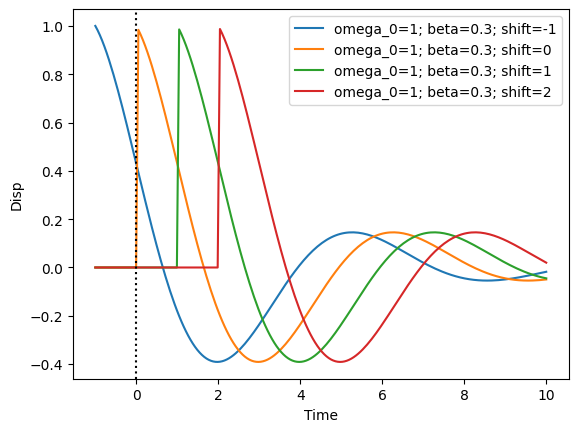

In [3]:
omega_0 = 1
beta = 0.3

t_vals = np.linspace(-1, 10, 200)
for shift in [-1, 0, 1, 2]:
    x_vals = damped_sho(t_vals, omega_0=omega_0, beta=beta, shift=shift)
    plt.plot(t_vals, x_vals, label=f"{omega_0=}; {beta=}; {shift=}")
plt.xlabel("Time")
plt.ylabel("Disp")
plt.axvline(x=0, linestyle='dotted', color='black')
plt.legend()

In [4]:
injection_parameters = dict(omega_0=omega_0, beta=beta, shift=2)

In [5]:
num_points = 200
t_vals = np.linspace(-1, 10, num_points)

In [6]:
sigma = 0.05

In [7]:
data = damped_sho(t_vals, **injection_parameters) + np.random.normal(0, sigma, t_vals.size)

Text(0, 0.5, 'y')

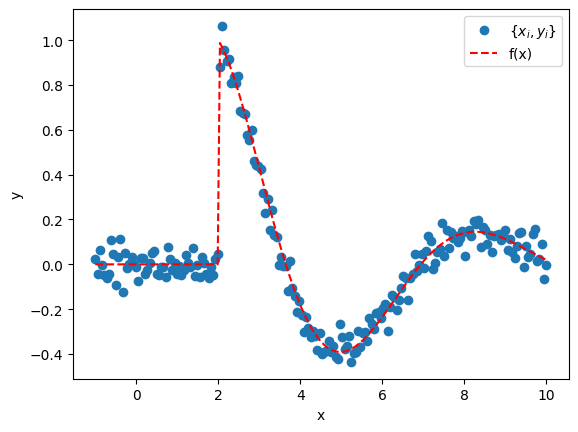

In [8]:
fig, ax = plt.subplots()
ax.plot(t_vals, data, 'o', label='$\\{x_i, y_i\\}$')
ax.plot(t_vals, damped_sho(t_vals, **injection_parameters), '--r', label='f(x)')
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')

In [9]:
import bilby
from bilby.core.prior import Uniform, DeltaFunction

## Prior for parameters

In [10]:
priors = dict()

priors['omega_0'] = Uniform(0.1, 2, name='omega_0', latex_label='$\omega_0$')
priors['beta'] = Uniform(0, 0.5, name='beta', latex_label='$\\beta$')
priors['shift'] = Uniform(-4, 4, name='shift', latex_label='$\Delta\;t$')

## Likelihood

In [11]:
# from bilby.core.likelihood import GaussianLikelihood

# log_l = GaussianLikelihood(t_vals, data, damped_sho, sigma=sigma)

In [12]:
# result = bilby.run_sampler(
#     likelihood=log_l, priors=priors, sampler='dynesty',
#     nlive=300, npool=4, save=False, clean=True,
#     injection_parameters=injection_parameters,
#     outdir='./damped_sho',
#     label='damped_sho'
# )

In [13]:
# result.plot_corner(priors=True)

# Train embedding space first

The aim is to make the network be agnostic to shift in time. Train embedding space to cluster shifts in intercept value.

In [14]:
from IPython.display import clear_output
from time import sleep

In [15]:
def get_data(omega_0=None, beta=None, shift=None, num_points=1):
    """Sample omega, beta, shift and return a batch of data with noise"""
    omega_0 = priors['omega_0'].sample() if omega_0 is None else omega_0
    beta = priors['beta'].sample() if beta is None else beta
    shift = priors['shift'].sample() if shift is None else shift
    t_vals = np.linspace(-1, 10, num_points)
    y = damped_sho(t_vals, omega_0=omega_0, beta=beta, shift=shift)
    y += sigma*np.random.normal(size=y.size)

    return t_vals, y, omega_0, beta, shift

# Add augmentation

In [16]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.tensorboard import SummaryWriter

In [17]:
num_simulations = 10000
theta_vals = []
data_vals = []
for ii in range(num_simulations):
    t_vals, y, omega, beta, shift = get_data(num_points=200, shift=0)
    data_vals.append(y)
    theta_vals.append([omega, beta, shift])

In [18]:
theta_vals = np.array(theta_vals)
data_vals = np.array(data_vals)

In [19]:
class DataGenerator(Dataset):
    def __len__(self):
        return num_simulations

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # augment the data to have several shifted intercepts
        theta, data_aug, data_orig = self.augment(idx)

        return (
            torch.from_numpy(theta).to(torch.float32),
            torch.from_numpy(data_aug).to(torch.float32),
            torch.from_numpy(data_orig).to(torch.float32)
        )

    def augment(self, idx):
        repeats = 30  # just a choice, can be different
        omega = theta_vals[idx][0]
        beta = theta_vals[idx][1]
        theta_aug_vals, data_aug_vals, data_orig_vals = [], [], []
        for _ in range(repeats):
            # reproduce every instance with zero shifts
            t_val, y_val_orig, omega_0, beta, shift = get_data(
                omega_0=omega, beta=beta, shift=0,
                num_points=num_points
            )
            data_orig_vals.append(y_val_orig)
            # augment every instance of natural freq and damping with several shifts
            t_val, y_val, omega_0, beta, shift = get_data(
                omega_0=omega, beta=beta, shift=None,
                num_points=num_points
            )
            data_aug_vals.append(y_val)

            theta_aug_vals.append([omega_0, beta, shift])
        return np.array(theta_aug_vals), np.array(data_aug_vals), np.array(data_orig_vals)

In [20]:
dataset = DataGenerator()

Text(0.5, 1.0, 'Augmented sample; Omega_0 = 0.5; Beta = 0.5')

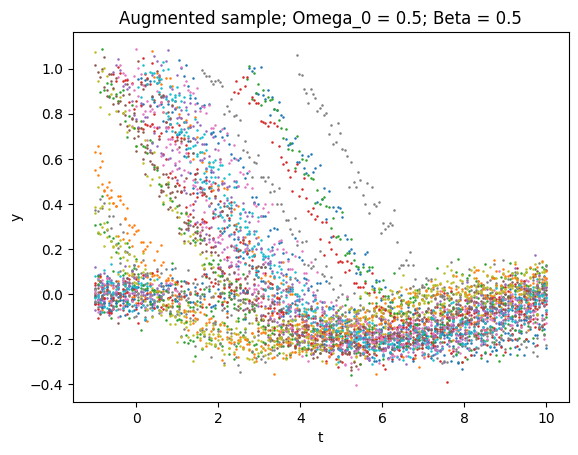

In [21]:
t, d, _ = dataset.augment(4)

fig, ax = plt.subplots()

for (omega, beta, shift), points in zip(t, d):
    ax.plot(t_vals, points, 'o', markersize=0.8, label='$\\{x_i, y_i\\}$')
ax.set_xlabel('t')
ax.set_ylabel('y')
ax.set_title(f"Augmented sample; Omega_0 = {t[0][0]:.1f}; Beta = {t[0][1]:.1f}")

In [22]:
train_set_size = int(0.8 * num_simulations)
val_set_size = int(0.1 * num_simulations)
test_set_size = int(0.1 * num_simulations)

train_data, val_data, test_data = torch.utils.data.random_split(
    dataset, [train_set_size, val_set_size, test_set_size])

In [23]:
TRAIN_BATCH_SIZE = 200
VAL_BATCH_SIZE = 50

train_data_loader = DataLoader(
    train_data, batch_size=TRAIN_BATCH_SIZE,
    shuffle=True
)

val_data_loader = DataLoader(
    val_data, batch_size=VAL_BATCH_SIZE,
    shuffle=True
)

test_data_loader = DataLoader(
    test_data, batch_size=1,
    shuffle=False
)

In [24]:
for theta, data_aug, data_orig in train_data_loader:
    break

In [25]:
theta.shape, data_aug.shape, data_orig.shape

(torch.Size([200, 30, 3]),
 torch.Size([200, 30, 200]),
 torch.Size([200, 30, 200]))

## Define similarity loss

In [26]:
# implemented from https://github.com/violatingcp/codec
class VICRegLoss(nn.Module):
    def __init__(self, lambda_param=1, mu_param=1,
                 nu_param=20, sort_tolerance=1.0,
                 sort_reg='l2'):
        
        super().__init__()
        self.lambda_param = lambda_param
        self.mu_param = mu_param
        self.nu_param = nu_param
        self.tolerance = sort_tolerance
        self.reg = sort_reg

    def forward(self, x, y):
        repr_loss = F.mse_loss(x, y)

        x = x - x.mean(dim=0)
        y = y - y.mean(dim=0)
        N = x.size(0)
        D = x.size(1)
        
        std_x = torch.sqrt(x.var(dim=0) + 0.0001)
        std_y = torch.sqrt(y.var(dim=0) + 0.0001)
        std_loss = torch.mean(F.relu(1 - std_x)) / 2 + torch.mean(F.relu(1 - std_y)) / 2

        x = (x-x.mean(dim=0))/x.std(dim=0)
        y = (y-y.mean(dim=0))/y.std(dim=0)

        # transpose dims 1 and 2; keep batch dim i.e. 0, unchanged
        cov_x = (x.transpose(1, 2) @ x) / (N - 1)
        cov_y = (y.transpose(1, 2) @ y) / (N - 1)
        cov_loss = self.off_diagonal(cov_x).pow_(2).sum().div(D)
        cov_loss += self.off_diagonal(cov_y).pow_(2).sum().div(D)

        return 2*repr_loss + 3*cov_loss + 5*std_loss

    def off_diagonal(self,x):
        num_batch, n, m = x.shape
        assert n == m
        # All off diagonal elements from complete batch flattened
        return x.flatten(start_dim=1)[...,:-1].view(num_batch, n - 1, n + 1)[...,1:].flatten()

In [27]:
vicreg_loss = VICRegLoss()

In [28]:
class SimilarityEmbedding(nn.Module):
    """Simple Dense embedding"""
    def __init__(self, num_hidden_layers=1, activation=torch.relu):
        super().__init__()
        self.num_hidden_layers = num_hidden_layers
        self.first_layer = nn.Linear(num_points, 100)
        self.layers = nn.ModuleList(
            [nn.Linear(100, 100) for _ in range(num_hidden_layers)])
        self.final_layer = nn.Linear(100, 2)
        self.activation = activation

    def forward(self, x):
        x = self.first_layer(x)
        x = self.activation(x)
        for layer in self.layers:
            x = layer(x)
            x = self.activation(x)
        x = self.final_layer(x)
        return x

In [29]:
similarity_embedding = SimilarityEmbedding(num_hidden_layers=5)

optimizer = optim.Adam(similarity_embedding.parameters(), lr=1e-3)

scheduler_1 = optim.lr_scheduler.ConstantLR(optimizer, total_iters=5)
scheduler_2 = optim.lr_scheduler.OneCycleLR(optimizer, total_steps=20, max_lr=2e-3)
scheduler_3 = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-5)

scheduler = optim.lr_scheduler.SequentialLR(
    optimizer, schedulers=[scheduler_1, scheduler_2, scheduler_3], milestones=[5, 20])

In [30]:
similarity_embedding(data_aug).shape

torch.Size([200, 30, 2])

In [31]:
emb_aug = similarity_embedding(data_aug)
emb_orig = similarity_embedding(data_orig)
vicreg_loss(emb_aug, emb_orig)

tensor(6.9821, grad_fn=<AddBackward0>)

In [32]:
# similarity_embedding_model_path = './_sho_similarity_embedding_linear.pt'
similarity_embedding_model_path = './_sho_similarity_embedding_linear_2.pt'
# torch.save(similarity_embedding.state_dict(), similarity_embedding_model_path)
similarity_embedding.load_state_dict(torch.load(similarity_embedding_model_path))

<All keys matched successfully>

In [33]:
def train_one_epoch(epoch_index, tb_writer):
    running_sim_loss = 0.
    last_sim_loss = 0.

    for idx, val in enumerate(train_data_loader, 1):
        augmented_theta, augmented_data, unshifted_data = val
        embedded_values_aug = similarity_embedding(augmented_data)
        embedded_values_orig = similarity_embedding(unshifted_data)

        similar_embedding_loss = vicreg_loss(
            embedded_values_aug,
            embedded_values_orig
        )

        optimizer.zero_grad()
        similar_embedding_loss.backward()
        optimizer.step()
        # Gather data and report
        running_sim_loss += similar_embedding_loss.item()
        if idx % 10 == 0:
            last_sim_loss = running_sim_loss / 10
            print(' Avg. train loss/batch after {} batches = {:.4f}'.format(idx, last_sim_loss))
            tb_x = epoch_index * len(train_data_loader) + idx
            tb_writer.add_scalar('SimLoss/train', last_sim_loss, tb_x)
            running_sim_loss = 0.
    return last_sim_loss


def val_one_epoch(epoch_index, tb_writer):
    running_sim_loss = 0.
    last_sim_loss = 0.

    for idx, val in enumerate(val_data_loader, 1):
        augmented_theta, augmented_data, unshifted_data = val
        embedded_values_aug = similarity_embedding(augmented_data)
        embedded_values_orig = similarity_embedding(unshifted_data)

        similar_embedding_loss = vicreg_loss(
            embedded_values_aug,
            embedded_values_orig
        )

        running_sim_loss += similar_embedding_loss.item()
        if idx % 10 == 0:
            last_sim_loss = running_sim_loss / 10
            tb_x = epoch_index * len(val_data_loader) + idx + 1
            tb_writer.add_scalar('SimLoss/val', last_sim_loss, tb_x)
            tb_writer.flush()
            running_sim_loss = 0.
    tb_writer.flush()
    return last_sim_loss

In [34]:
# writer = SummaryWriter("sho_linear_embedding_round_2", comment="Similarity with LR=1e-3", flush_secs=5)
# epoch_number = 0

In [35]:
# %%time
# # UNCOMMENT AND RUN TO TRAIN FROM SCRATCH
# EPOCHS = 50

# for epoch in range(EPOCHS):
#     print('EPOCH {}:'.format(epoch_number + 1))
#     # Gradient tracking
#     similarity_embedding.train(True)
#     avg_train_loss = train_one_epoch(epoch_number, writer)
    
#     # no gradient tracking, for validation
#     similarity_embedding.train(False)
#     avg_val_loss = val_one_epoch(epoch_number, writer)
    
#     print(f"Train/Val Sim Loss after epoch: {avg_train_loss:.4f}/{avg_val_loss:.4f}")

#     epoch_number += 1
#     scheduler.step()

## See embedded space

In [36]:
similarity_embedding.train(False)

similarity_outputs_1 = []

for idx, (theta_test, data_test, data_test_orig) in enumerate(test_data):
    if not ((theta_test.T[0][1] < 0.2) and (theta_test.T[0][1] > 0.1)):
        continue
    with torch.no_grad():
        similarity_output = similarity_embedding(data_test)
    similarity_outputs_1.append(similarity_output.numpy())

similarity_outputs_2 = []

for idx, (theta_test, data_test, data_test_orig) in enumerate(test_data):
    if not ((theta_test.T[0][1] < 0.5) and (theta_test.T[0][1] > 0.4)):
        continue
    with torch.no_grad():
        similarity_output = similarity_embedding(data_test)
    similarity_outputs_2.append(similarity_output.numpy())

# similarity_outputs_1 = []

# for idx, (theta_test, data_test, data_test_orig) in enumerate(test_data):
#     if not ((theta_test.T[0][0] < 0.4) and (theta_test.T[0][0] > 0.2)):
#         continue
#     with torch.no_grad():
#         similarity_output = similarity_embedding(data_test)
#     similarity_outputs_1.append(similarity_output.numpy())

# similarity_outputs_2 = []

# for idx, (theta_test, data_test, data_test_orig) in enumerate(test_data):
#     if not ((theta_test.T[0][0] < 1.6) and (theta_test.T[0][0] > 1.5)):
#         continue
#     with torch.no_grad():
#         similarity_output = similarity_embedding(data_test)
#     similarity_outputs_2.append(similarity_output.numpy())

In [37]:
similarity_outputs_1 = np.array(similarity_outputs_1)
similarity_outputs_2 = np.array(similarity_outputs_2)

In [38]:
similarity_outputs_1.shape

(54, 30, 2)

### See projections of different $\omega_0$ and $\beta$ values

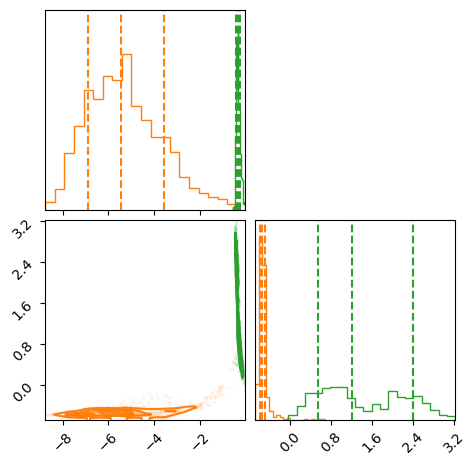

In [39]:
import corner

figure = corner.corner(
    similarity_outputs_1.reshape((similarity_outputs_1.shape[0]*similarity_outputs_1.shape[1], 2)),
    quantiles=[0.16, 0.5, 0.84], color="C1"
)

figure = corner.corner(
    similarity_outputs_2.reshape((similarity_outputs_2.shape[0]*similarity_outputs_2.shape[1], 2)),
    quantiles=[0.16, 0.5, 0.84], fig=figure, color="C2"
)

# Freeze weights, used as embedding network in MAF

In [40]:
from nflows.distributions import StandardNormal
from nflows.flows import Flow
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms import CompositeTransform, RandomPermutation

import nflows.utils as torchutils

In [41]:
# make embeddeding net untrainable
for name, param in similarity_embedding.named_parameters():
    param.requires_grad = False

In [42]:
num_transforms = 2
num_blocks = 2
hidden_features = 10

context_features = similarity_embedding(data_aug).shape[-1]

base_dist = StandardNormal([2])

transforms = []
for _ in range(num_transforms):
    block = [
        MaskedAffineAutoregressiveTransform(
            features=2,  # 2-dim posterior
            hidden_features=hidden_features,
            context_features=context_features,
            num_blocks=num_blocks,
            activation=torch.tanh,
            use_batch_norm=False,
            use_residual_blocks=True,
            dropout_probability=0.01
        ),
        RandomPermutation(features=2)
    ]
    transforms += block

transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist, similarity_embedding)

In [43]:
print("Total number of trainable parameters: ", sum(p.numel() for p in flow.parameters() if p.requires_grad))

Total number of trainable parameters:  1208


In [44]:
# flow_model_path = './sho_flow_model_linear_embedding_2.pt'
# torch.save(flow.state_dict(), flow_model_path)
# flow.load_state_dict(torch.load(flow_model_path))

# Train/Validate

In [45]:
num_augmentations = 1

def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    for idx, val in enumerate(train_data_loader, 1):
        augmented_theta, augmented_data, orig_data = val
        loss = 0
        for ii in range(num_augmentations):
            theta = augmented_theta[:,ii,:]
            # drop the shift value entirely
            theta = theta.T[:-1].T
            data = augmented_data[:,ii,:]
            flow_loss = -flow.log_prob(theta, context=data).mean()

            optimizer.zero_grad()
            flow_loss.backward()
            optimizer.step()
            
            loss += flow_loss.item()

        running_loss += loss/num_augmentations
        if idx % 10 == 0:
            last_loss = running_loss / 10 # avg loss
            print(' Avg. train loss/batch after {} batches = {:.4f}'.format(idx, last_loss))
            tb_x = epoch_index * len(train_data_loader) + idx
            tb_writer.add_scalar('Flow Loss/train', last_loss, tb_x)
            tb_writer.flush()
            running_loss = 0.
    return last_loss


def val_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    for idx, val in enumerate(val_data_loader, 1):
        augmented_theta, augmented_data, orig_data = val
        loss = 0
        for ii in range(num_augmentations):
            theta = augmented_theta[:,ii,:]
            # drop the shift value entirely
            theta = theta.T[:-1].T
            data = augmented_data[:,ii,:]

            flow_loss = -flow.log_prob(theta, context=data).mean()
            loss += flow_loss.item()

        running_loss += loss/num_augmentations
        if idx % 10 == 0:
            last_loss = running_loss / 10
            tb_x = epoch_index * len(val_data_loader) + idx + 1
            tb_writer.add_scalar('Flow Loss/val', last_loss, tb_x)

            tb_writer.flush()
            running_loss = 0.
    tb_writer.flush()
    return last_loss

In [46]:
optimizer = optim.Adam(flow.parameters(), lr=2e-3)

scheduler_1 = optim.lr_scheduler.ConstantLR(optimizer, total_iters=5)
scheduler_2 = optim.lr_scheduler.OneCycleLR(optimizer, total_steps=20, max_lr=2e-3)
scheduler_3 = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

scheduler = optim.lr_scheduler.SequentialLR(
    optimizer, schedulers=[scheduler_1, scheduler_2, scheduler_3], milestones=[5, 20])

In [47]:
writer = SummaryWriter("sho_flow_linear_embedding_3", comment="With LR=1e-3", flush_secs=5)
epoch_number = 0

In [48]:
%%time
# UNCOMMENT AND RUN TO TRAIN FROM SCRATCH
EPOCHS = 50

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    # Gradient tracking
    flow.train(True)
    # flow._embedding_net.train(False)
    # no gradient tracking for embedding layer
    for name, param in flow._embedding_net.named_parameters():
        param.requires_grad = False

    avg_train_loss = train_one_epoch(epoch_number, writer)

    # no gradient tracking, for validation
    flow.train(False)
    avg_val_loss = val_one_epoch(epoch_number, writer)

    print(f"Train/Val flow Loss after epoch: {avg_train_loss:.4f}/{avg_val_loss:.4f}")

    epoch_number += 1
    scheduler.step()

EPOCH 1:
 Avg. train loss/batch after 10 batches = 4.2688
 Avg. train loss/batch after 20 batches = 4.2963
 Avg. train loss/batch after 30 batches = 4.2331
 Avg. train loss/batch after 40 batches = 4.2379
Train/Val flow Loss after epoch: 4.2379/4.2282
EPOCH 2:
 Avg. train loss/batch after 10 batches = 4.2194
 Avg. train loss/batch after 20 batches = 4.2167
 Avg. train loss/batch after 30 batches = 4.1863
 Avg. train loss/batch after 40 batches = 4.1709
Train/Val flow Loss after epoch: 4.1709/4.1950
EPOCH 3:
 Avg. train loss/batch after 10 batches = 4.1678
 Avg. train loss/batch after 20 batches = 4.1362
 Avg. train loss/batch after 30 batches = 4.1296
 Avg. train loss/batch after 40 batches = 4.1199
Train/Val flow Loss after epoch: 4.1199/4.0842
EPOCH 4:
 Avg. train loss/batch after 10 batches = 4.1118
 Avg. train loss/batch after 20 batches = 4.0914
 Avg. train loss/batch after 30 batches = 4.0681
 Avg. train loss/batch after 40 batches = 4.0453
Train/Val flow Loss after epoch: 4.0453

/home/deep/miniconda3/envs/mlpe-base/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


 Avg. train loss/batch after 10 batches = 3.9776
 Avg. train loss/batch after 20 batches = 3.9247
 Avg. train loss/batch after 30 batches = 3.8875
 Avg. train loss/batch after 40 batches = 3.8392
Train/Val flow Loss after epoch: 3.8392/3.8352
EPOCH 7:
 Avg. train loss/batch after 10 batches = 3.7565
 Avg. train loss/batch after 20 batches = 3.6142
 Avg. train loss/batch after 30 batches = 3.4660
 Avg. train loss/batch after 40 batches = 3.3412
Train/Val flow Loss after epoch: 3.3412/3.2791
EPOCH 8:
 Avg. train loss/batch after 10 batches = 3.0604
 Avg. train loss/batch after 20 batches = 2.6383
 Avg. train loss/batch after 30 batches = 2.2086
 Avg. train loss/batch after 40 batches = 1.7762
Train/Val flow Loss after epoch: 1.7762/1.5761
EPOCH 9:
 Avg. train loss/batch after 10 batches = 1.2736
 Avg. train loss/batch after 20 batches = 0.7374
 Avg. train loss/batch after 30 batches = 0.3528
 Avg. train loss/batch after 40 batches = 0.0986
Train/Val flow Loss after epoch: 0.0986/0.0230
E

Train/Val flow Loss after epoch: -0.9331/-0.9585
EPOCH 38:
 Avg. train loss/batch after 10 batches = -0.8802
 Avg. train loss/batch after 20 batches = -0.9418
 Avg. train loss/batch after 30 batches = -0.8909
 Avg. train loss/batch after 40 batches = -0.8811
Train/Val flow Loss after epoch: -0.8811/-0.8734
EPOCH 39:
 Avg. train loss/batch after 10 batches = -0.8862
 Avg. train loss/batch after 20 batches = -0.8859
 Avg. train loss/batch after 30 batches = -0.9061
 Avg. train loss/batch after 40 batches = -0.8894
Train/Val flow Loss after epoch: -0.8894/-0.9290
EPOCH 40:
 Avg. train loss/batch after 10 batches = -0.8769
 Avg. train loss/batch after 20 batches = -0.9150
 Avg. train loss/batch after 30 batches = -0.9027
 Avg. train loss/batch after 40 batches = -0.8791
Train/Val flow Loss after epoch: -0.8791/-0.8500
EPOCH 41:
 Avg. train loss/batch after 10 batches = -0.8901
 Avg. train loss/batch after 20 batches = -0.8618
 Avg. train loss/batch after 30 batches = -0.9301
 Avg. train lo

# Check on test data

In [49]:
import pandas as pd

def cast_as_bilby_result(samples, truth):
    injections = dict.fromkeys({'omega_0', 'beta'})
    injections['omega_0'] = float(truth.numpy()[0])
    injections['beta'] = float(truth.numpy()[1])

    posterior = dict.fromkeys({'omega_0', 'beta'})
    samples_numpy = samples.numpy()
    posterior['omega_0'] = samples_numpy.T[0].flatten()
    posterior['beta'] = samples_numpy.T[1].flatten()
    posterior = pd.DataFrame(posterior)
    
    return bilby.result.Result(
        label="test_data",
        injection_parameters=injections,
        posterior=posterior,
        search_parameter_keys=list(injections.keys()),
        priors=priors
    )

## Posterior

In [50]:
def live_plot_samples(samples, truth):
    clear_output(wait=True)
    sleep(0.5)
    figure = corner.corner(
        samples.numpy(), quantiles=[0.16, 0.5, 0.84],
        show_titles=True,
        labels=["omega_0", "beta",],
        truth=truth,
    )

    corner.overplot_lines(figure, truth, color="C1")
    corner.overplot_points(figure, truth[None], marker="s", color="C1")
#     corner.overplot_lines(figure, truth[:-1], color="C1")
#     corner.overplot_points(figure, truth[:-1][None], marker="s", color="C1")

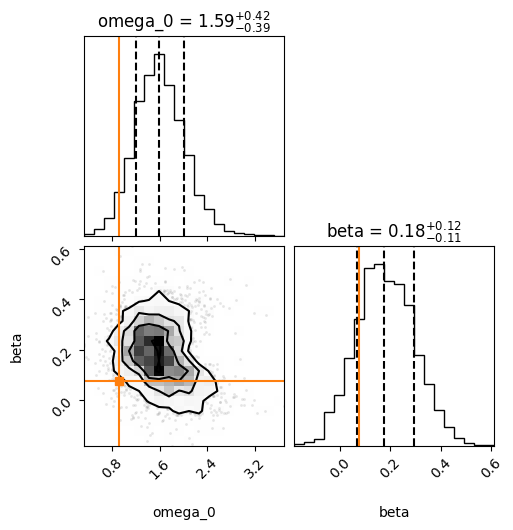

In [51]:
for idx, (theta_test, data_test, data_orig) in enumerate(test_data):
    if idx % 10 !=0: continue 
    with torch.no_grad():
        samples = flow.sample(3000, context=data_test[0].reshape((1, 200)))
    live_plot_samples(samples[0], theta_test[0][:-1])
    plt.show()

# PP plot

17:06 bilby INFO    : Key: KS-test p-value
17:06 bilby INFO    : omega_0: 0.057069391120230684
17:06 bilby INFO    : beta: 2.423709624155752e-07
17:06 bilby INFO    : Combined p-value: 2.6413909498374595e-07


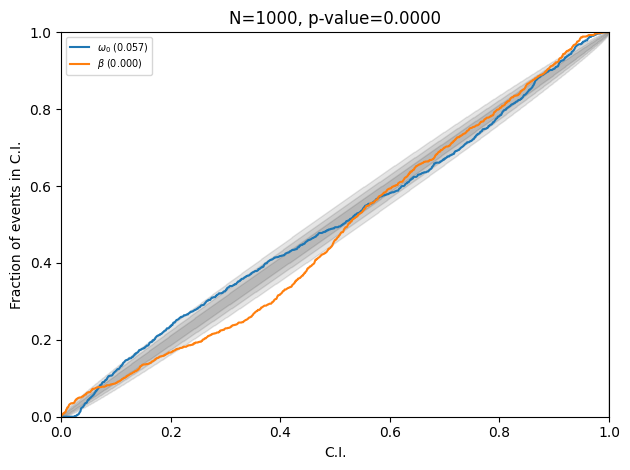

In [52]:
results = []
for idx, (theta_test, data_test, data_unshifted) in enumerate(test_data):
    with torch.no_grad():
        samples = flow.sample(3000, context=data_test[0].reshape((1, 200)))
    results.append(
        cast_as_bilby_result(samples, theta_test[0]))

import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    bilby.result.make_pp_plot(results, save=False, keys=['omega_0', 'beta'])

In [53]:
stds = pd.concat([r.posterior.std() for r in results], axis=1).T

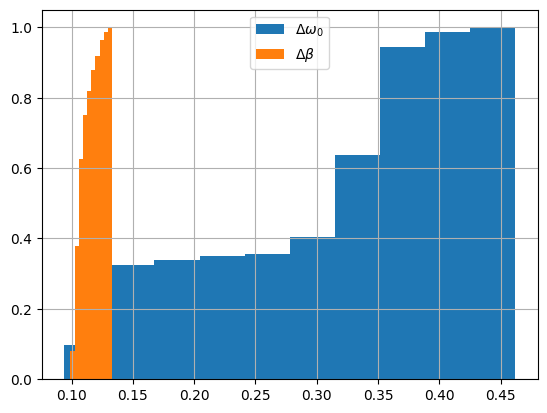

In [54]:
fig, ax = plt.subplots()
stds.omega_0.hist(cumulative=True, density=True, ax=ax, label='$\Delta\omega_0$')
stds.beta.hist(cumulative=True, density=True, ax=ax, label='$\Delta\\beta$')
plt.legend()